# Intro to NLP

In [1]:
%load_ext lab_black

import pandas as pd
import nltk

In [2]:
df = pd.read_csv("input/Reviews.csv")
review = df["Text"].values[0]
tokens = nltk.word_tokenize(review)
tagged = nltk.pos_tag(tokens)

In [38]:
entities = nltk.chunk.ne_chunk(tagged)

# How to Run Sentiment Analysis on Text

<AxesSubplot:title={'center':'Score of Reviews'}>

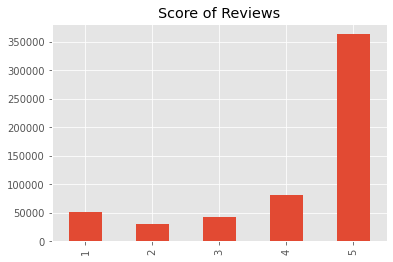

In [58]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df['Score'].value_counts().sort_index().plot(kind='bar', title='Score of Reviews')

# Tokenize the Reviews

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

# tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r"[a-zA-Z0-9]+")
cv = CountVectorizer(
    lowercase=True, stop_words="english", ngram_range=(1, 1), tokenizer=token.tokenize
)
# text_counts= cv.fit_transform(df['Phrase'])

In [62]:
text_counts = cv.fit_transform(df["Text"])

# Vadar Sentiment

In [36]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [117]:
res = {}
i = 0
for d in tqdm(df.itertuples(), total=len(df)):
    myid = d[1]
    text = d[-1]
    res[myid] = sia.polarity_scores(text)
    i += 1
    if i == 10_000:
        break

  0%|          | 0/568454 [00:00<?, ?it/s]

In [126]:
vadars = pd.DataFrame(res).T
vadars = vadars.reset_index().rename(columns={"index": "Id"})
vadars = vadars.merge(df, how="left")

In [130]:
import seaborn as sns

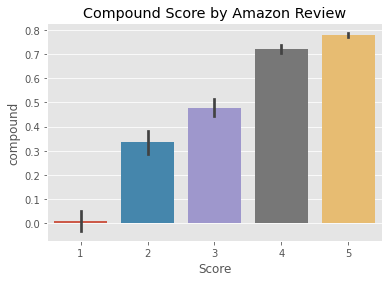

In [140]:
ax = sns.barplot(data=vadars, x="Score", y="compound")
ax.set_title("Compound Score by Amazon Review")
plt.show()

In [146]:
# vadars

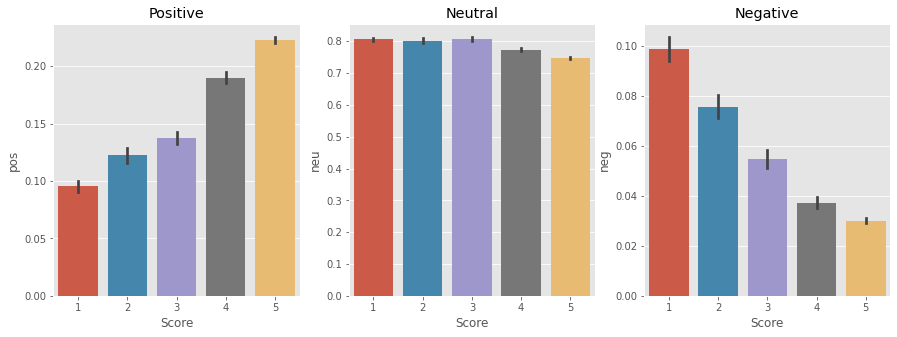

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vadars, x="Score", y="pos", ax=axs[0])
sns.barplot(data=vadars, x="Score", y="neu", ax=axs[1])
sns.barplot(data=vadars, x="Score", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()

In [159]:
vadars["pos_plus_neg"] = vadars[["pos", "neg"]].sum(axis=1)

In [162]:
vadars.query("neg > 0 and pos > 0").sort_values("pos_plus_neg", ascending=False)[
    "Text"
].values[0]

'great tasting coffee. strong, but not obnoxiously strong and no nasty aftertaste. too bad, it cannot be purchased on subscribe and save anymore.'

# Try Seniment Analysis with BERT

In [3]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

2022-05-01 22:19:17.371732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.5/lib64:/usr/lib/x86_64-linux-gnu
2022-05-01 22:19:17.371758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-05-01 22:20:17.698661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.5/lib64:/usr/lib/x86_64-linux-gnu
2022-05-01 22:20:17.698793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.5/lib64:/usr/lib/x86_64-linux-gnu
2022-05-01 22:20:17.698889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.5/lib64:/usr/lib/x86_64-linux-gnu
2022-05-01 22:20:17.698987: W tenso

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [11]:
pred_sentences = df["Text"].values[:5].tolist()

In [12]:
tf_batch = tokenizer(
    pred_sentences, max_length=128, padding=True, truncation=True, return_tensors="tf"
)

In [13]:
tf_outputs = model(tf_batch)

In [16]:
import tensorflow as tf

In [17]:
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)

In [19]:
labels = ["Negative", "Positive"]
label = tf.argmax(tf_predictions, axis=1)

In [21]:
label = label.numpy()

# Roberta Sentiment Analysis

In [28]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = "@user" if t.startswith("@") and len(t) > 1 else t
        t = "http" if t.startswith("http") else t
        new_text.append(t)
    return " ".join(new_text)


# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task = "sentiment"
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

## Download Pretrained Model

In [29]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [44]:
df["Text"].head(20).values[-1]

'Candy was delivered very fast and was purchased at a reasonable price.  I was home bound and unable to get to a store so this was perfect for me.'

# Testing Examples

In [50]:
text = "that guy is a badass"

# roberta Prediction
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

print("Vadar Scores:")
print(sia.polarity_scores(text))
print("roberta Scores")
print(f"neg {scores[0]:0.3f}, neu {scores[1]:0.3f}, pos {scores[2]:0.3f}")

Vadar Scores:
{'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'compound': -0.1531}
roberta Scores
neg 0.008, neu 0.086, pos 0.905


In [67]:
pd.DataFrame(res).T

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600
3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063
...,...,...,...,...,...,...,...
78,0.034,0.798,0.168,0.8303,0.003559,0.027854,0.968587
79,0.000,0.763,0.237,0.7814,0.004849,0.052556,0.942595
80,0.087,0.589,0.324,0.8636,0.626154,0.282115,0.091731
81,0.000,0.723,0.277,0.9098,0.001572,0.006270,0.992158


In [118]:
res = {}
i = 0
for d in tqdm(df.itertuples(), total=len(df)):
    try:
        myid = d[1]
        text = d[-1]
        result = sia.polarity_scores(text)
        # roberta
        encoded_input = tokenizer(text, return_tensors="pt")
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        result["roberta_neg"] = scores[0]
        result["roberta_neu"] = scores[1]
        result["roberta_pos"] = scores[2]
        res[myid] = result
    except:
        print("broke")
    i += 1
    if i == 1_000:
        break

  0%|          | 0/568454 [00:00<?, ?it/s]

broke
broke
broke
broke
broke
broke


In [ ]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [119]:
sent = pd.DataFrame(res).T
sent = sent.reset_index().rename(columns={"index": "Id"})
sent = sent.merge(df, how="left")

sent["pos_diff"] = np.abs(sent["pos"] - sent["roberta_pos"])
sent["neg_diff"] = np.abs(sent["neg"] - sent["roberta_neg"])
sent["neu_diff"] = np.abs(sent["neu"] - sent["roberta_neu"])

In [120]:
def plot_id(sent, myid=5):
    ax = sent.query("Id == @myid")[
        [
            "neg",
            "neu",
            "pos",
            "roberta_neg",
            "roberta_neu",
            "roberta_pos",
        ]
    ].plot(kind="bar")
    print(sent.query("Id == @myid")["Text"].values[0])
    plt.show()

This seems a little more wholesome than some of the supermarket brands, but it is somewhat mushy and doesn't have quite as much flavor either.  It didn't pass muster with my kids, so I probably won't buy it again.


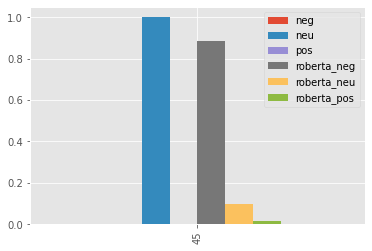

In [121]:
plot_id(sent, 46)

# Compare Roberta Scores vs Amazon Review Stars

In [122]:
import seaborn as sns

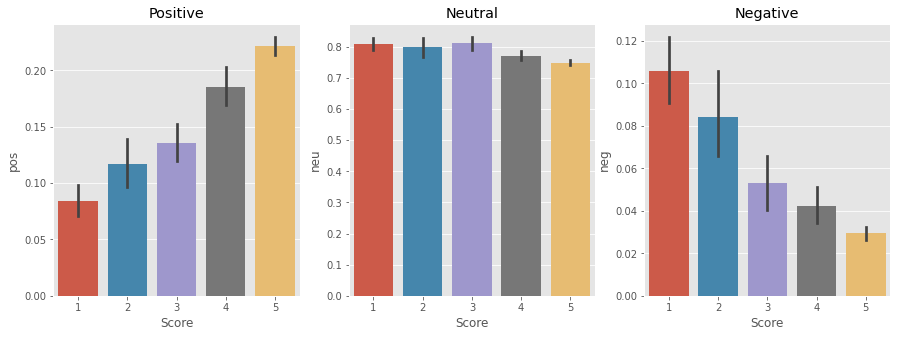

In [124]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=sent, x="Score", y="pos", ax=axs[0])
sns.barplot(data=sent, x="Score", y="neu", ax=axs[1])
sns.barplot(data=sent, x="Score", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()

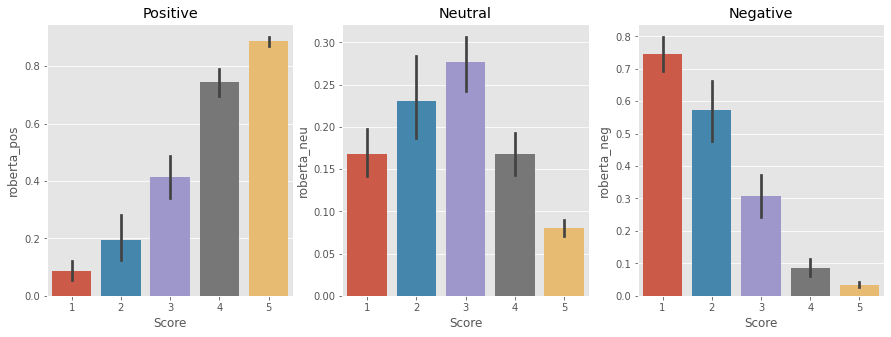

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=sent, x="Score", y="roberta_pos", ax=axs[0])
sns.barplot(data=sent, x="Score", y="roberta_neu", ax=axs[1])
sns.barplot(data=sent, x="Score", y="roberta_neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()

# What's the most "Positive" 1 star review?

In [134]:
# sent.query("Score == 1").sort_values("roberta_pos", ascending=False)

I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months.


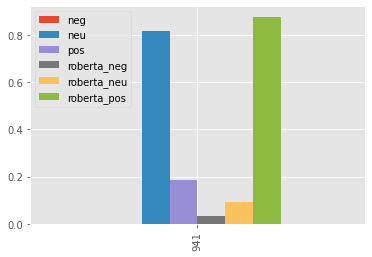

In [136]:
plot_id(sent, 948)

If it were possible to give this product zero stars, I would have done so.  I am a huge fan of Twinings teas, and was very excited to try this new blend.  After arriving home from the grocery, I immediately started the kettle to enjoy a cup while prepping dinner.  Between sorting, washing, and chopping items, the hot water was added to the bag to steep.  Preparation continued, until a distinctly off odor hit me.  I thought one of my ingredients must be rancid!  I hunted around for almost four minutes before I realized it was the tea.  Even after cleaning up, and airing out the kitchen, my roommate later came in and asked about the smell.  Save your money to purchase ANY other Twinings product.


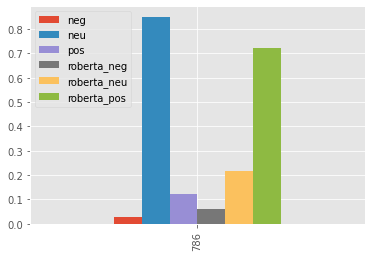

In [143]:
myid = (
    sent.query("Score == 1").sort_values("roberta_pos", ascending=False)["Id"].values[1]
)
plot_id(sent, myid)

# What's the most "Negative" 5 star review?

this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


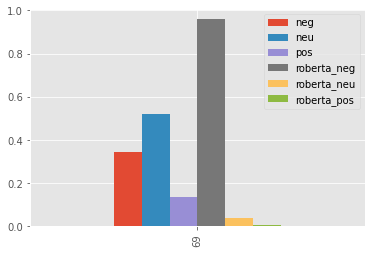

In [141]:
myid = (
    sent.query("Score == 5").sort_values("roberta_neg", ascending=False)["Id"].values[0]
)
plot_id(sent, myid)

If this flavor lasted longer than it does, I'd probably die of starvation for lack of wanting to take it out of my mouth.


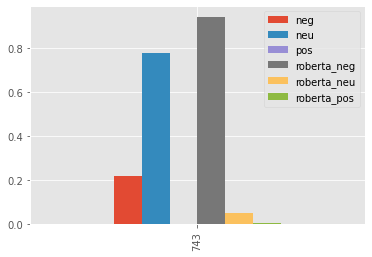

In [142]:
myid = (
    sent.query("Score == 5").sort_values("roberta_neg", ascending=False)["Id"].values[1]
)
plot_id(sent, myid)

# Most Helpful Reviews

In [149]:
sent["helpful_pct"] = sent["HelpfulnessNumerator"] / sent["HelpfulnessDenominator"]

In [154]:
sent.query("HelpfulnessNumerator > 10 and helpful_pct >= 1")

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,...,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,pos_diff,neg_diff,neu_diff,helpful_pct
32,33,0.069,0.839,0.092,0.7103,0.118533,0.329442,0.552025,B001EO5QW8,AOVROBZ8BNTP7,...,19,19,4,1163376000,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,0.460025,0.049533,0.509558,1.0
33,34,0.024,0.720,0.256,0.9779,0.004969,0.051026,0.944004,B001EO5QW8,A3PMM0NFVEJGK9,...,13,13,4,1166313600,Good Instant,This is a good instant oatmeal from the best o...,0.688004,0.019031,0.668974,1.0
285,288,0.035,0.801,0.163,0.9676,0.326378,0.374800,0.298822,B001UJEN6C,A1XM65S80UQ2MD,...,13,13,5,1276214400,Great Natural Energy,"This is a fantastic product, and I wish it was...",0.135822,0.291378,0.426200,1.0
649,654,0.038,0.890,0.072,0.7588,0.056404,0.404657,0.538939,B002BCD2OG,A2ZE5ICI6LWAZ0,...,27,27,5,1259193600,"Caramel flavor, excellent for baking and toppi...",If you want to find a good flavor substitute f...,0.466939,0.018404,0.485343,1.0
650,655,0.000,0.909,0.091,0.4404,0.015484,0.103408,0.881108,B002BCD2OG,A2LYOW4YW8R2HO,...,12,12,4,1292371200,These weigh 46 oz. NOT 46 fluid ounces,Good quality nectar. Very tasty.<br /><br />H...,0.790108,0.015484,0.805592,1.0
826,832,0.085,0.864,0.051,-0.2755,0.881157,0.107404,0.011439,B000IXUISS,A212N0TUR007EK,...,11,11,1,1274745600,Very Different taste from the 'Made in UK' or ...,The US made version of this Cadbury chocolate ...,0.039561,0.796157,0.756596,1.0


The US made version of this Cadbury chocolate has a distinct taste from the UK version of the chocolate which I have been eating since childhood. I did not like this new taste. To all my friends from India -- buy this chocolate if it is either made in UK or India; otherwise you will be disappointed as I was.


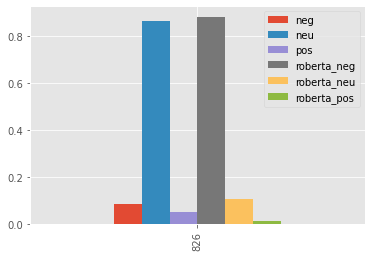

In [156]:
plot_id(sent, 832)

# Try the Transformers Pipeline

In [157]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

In [174]:
sent_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    binary_output=True,
)

In [175]:
sent_pipeline("I like you. I love you")

[{'label': '5 stars', 'score': 0.7865128517150879}]